# **Land Classificaton (Supervised) using Google Earth Engine (GEE) API**

###Importing Packages

In [1]:
!lscpu
# !nvidia-smi
# !pip install geemap
# !pip install geemap[extra]
# !pip install earthengine-api==0.1.375

Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          46 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   2
  On-line CPU(s) list:    0,1
Vendor ID:                GenuineIntel
  Model name:             Intel(R) Xeon(R) CPU @ 2.00GHz
    CPU family:           6
    Model:                85
    Thread(s) per core:   2
    Core(s) per socket:   1
    Socket(s):            1
    Stepping:             3
    BogoMIPS:             4000.34
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 cl
                          flush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc re
                          p_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3
                           fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand
                           hypervisor lahf_lm abm 3dnowprefetch i

**Authenticate with GEE repo**

In [2]:
import matplotlib.pyplot as plt
import ee
import numpy as np
# Trigger the authentication flow.
ee.Authenticate()
ee.Initialize(project='ee-sabyasachi')
import geemap

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init


###Classification

**Data Preparation**

In [3]:
##### Data Preparation ####
#Area of interest (From Custom Area Polygon)
aoi = ee.FeatureCollection('projects/ee-sabyasachi/assets/chennaidist')

#Making clean data (cloud removing)
startDate = '2019-06-01';
endDate = '2020-08-01';

#Function to mask clouds using the Sentinel-2 QA band
# enter {ee.Image} image Sentinel-2 image
# return {ee.Image} cloud masked Sentinel-2 image

def maskS2clouds(image):
  qa = image.select('QA60')
  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloudBitMask = 1 << 10
  cirrusBitMask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd(cloudBitMask).eq(0)\
            .bitwiseAnd(qa.bitwiseAnd(cirrusBitMask).eq(0))
  return image.updateMask(mask).divide(9900)

#Ready the data set
# Pre-filter to get less cloudy granules.\
dataset = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
                  .filterDate(startDate, endDate)\
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',1))\
                  .map(maskS2clouds);




img = dataset.mean().clip(aoi).select('B.*')
display('Band Name', img.bandNames())

#Plotting AOI and True Image
Map = geemap.Map(height = '600px', width = '600px')
Map.set_center(80.27569080958169,13.081809693304068, 12)
Map.add_layer(aoi, {'color': 'd4a048'}, 'AOI')
Map.add_layer(
    img, {'bands': ['B4', 'B3', 'B2'], 'min': 0.0, 'max': 0.3}, 'True Image'
)


Map

'Band Name'

Map(center=[13.081809693304068, 80.27569080958169], controls=(WidgetControl(options=['position', 'transparent_…

**Sampelling**

In [4]:
#### Sampling ####

# ESA WorldCover land cover map, used as label source in classifier training.
lc = ee.Image('ESA/WorldCover/v100/2020')


#region of Sampelling
ros = ee.Geometry.Polygon([
  [ [80.15590671633811,12.97507927322351], [80.21015141896918,12.966046129101052],
  [80.18749225806856,12.891426454269098], [80.24070699556945,12.863982087993108],
  [80.29117517688286,13.133942151489018], [80.20877805176653,13.110202700127267],
  [80.19504533662266,13.050008317968114], [80.19229877112474,13.019236650612344],
  [80.12981435102459,13.021243642907628], [80.15590671633811,12.97507927322351]]])


# Remap the land cover class values to a 0-based sequential series.
class_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 100]
remap_values = ee.List.sequence(0, 10)
label = 'lc'
lc = lc.remap(class_values, remap_values).rename(label).toByte()

# Add land cover as a band of the reflectance image and sample 100 pixels at
# 10 m scale from each land cover class within a region of interest.
sample = img.addBands(lc).stratifiedSample(
    numPoints=3000, classBand=label, region=ros, scale=300, geometries=True
)

# Add a random value field to the sample and use it to approximately split 80%
# of the features into a training set and 20% into a validation set.
sample = sample.randomColumn()
training_sample = sample.filter('random <= 0.8')
validation_sample = sample.filter('random > 0.8')

##plotting Sample and validation points
Map = geemap.Map(height = '600px', width = '600px')
Map.set_center(80.27569080958169,13.081809693304068, 12)
Map.add_layer(aoi, {'color': 'd4a048'}, 'AOI')
Map.add_layer(ros, {'color': 'white'}, 'Sampling Area', True)
Map.add_layer(training_sample, {'color': 'black'}, 'Training sample', True)
Map.add_layer(
    validation_sample, {'color': 'red'}, 'Validation sample', True
)

Map

Map(center=[13.081809693304068, 80.27569080958169], controls=(WidgetControl(options=['position', 'transparent_…

**Building Model**

In [5]:
#### Building the RF Model ####

# Train a 10-tree random forest classifier from the training sample.
trained_classifier = ee.Classifier.smileRandomForest(20).train(
    features=training_sample,
    classProperty=label,
    inputProperties=img.bandNames(),
)
# Classify the reflectance image from the trained classifier.
img_classified = img.classify(trained_classifier)


**Displaying all Result**

In [6]:
#### Displaying all Result and analysis of Model ####

# Get information about the trained classifier.
display('Results of trained classifier', trained_classifier.explain())

# Get a confusion matrix and overall accuracy for the training sample.
train_accuracy = trained_classifier.confusionMatrix()
display('Training error matrix', train_accuracy)
display('Training overall accuracy', train_accuracy.accuracy())

# Get a confusion matrix and overall accuracy for the validation sample.
validation_sample = validation_sample.classify(trained_classifier)
validation_accuracy = validation_sample.errorMatrix(label, 'classification')
display('Validation error matrix', validation_accuracy)
display('Validation accuracy', validation_accuracy.accuracy())


'Results of trained classifier'

'Training error matrix'

'Training overall accuracy'

'Validation error matrix'

'Validation accuracy'

**Plottig Classified image**

In [7]:
#### Visual of Classified Image ####
# Adding the layers to the map.
class_vis = {
    'min': 0,
    'max': 10,
    'palette': [
        '006400',
        'ffbb22',
        'ffff4c',
        'f096ff',
        'fa0000',
        'b4b4b4',
        'f0f0f0',
        '0064c8',
        '0096a0',
        '00cf75',
        'fae6a0',
    ],
}


#Plotting Classified Image
Map = geemap.Map(height = '600px', width = '600px')
Map.set_center(80.27569080958169,13.081809693304068, 12)
Map.add_layer(lc.clip(aoi), class_vis, 'ESA LC')
Map.add_layer(img_classified, class_vis, 'Classified')
Map.add_legend(title="ESA World Cover", builtin_legend='ESA_WorldCover')

Map

Map(center=[13.081809693304068, 80.27569080958169], controls=(WidgetControl(options=['position', 'transparent_…

**Calculating and plotting Percentages of all type of land**

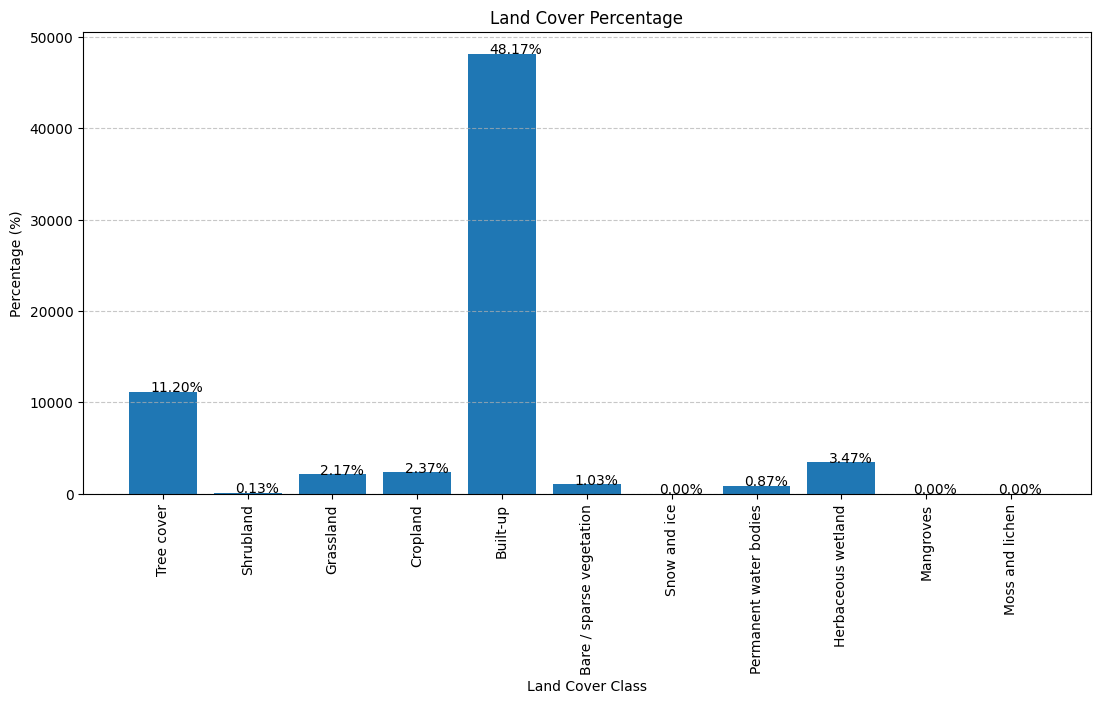

In [8]:
# Create a dictionary to map class labels to class names
class_label_to_name = {
    0: 'Tree cover',
    1: 'Shrubland',
    2: 'Grassland',
    3: 'Cropland',
    4: 'Built-up',
    5: 'Bare / sparse vegetation',
    6: 'Snow and ice',
    7: 'Permanent water bodies',
    8: 'Herbaceous wetland',
    9: 'Mangroves',
    10: 'Moss and lichen'
}

# Extract the land cover percentages as a Python dictionary
landcover_percentages = img_classified.reduceRegions(
    reducer=ee.Reducer.frequencyHistogram(),
    scale=30,
    collection=training_sample
)
landcover_dict = landcover_percentages.getInfo()['features']

# Initialize an empty dictionary to store class percentages by class name
class_percentages = {class_name: 0 for class_name in class_label_to_name.values()}

# Calculate percentages for each class
total_samples = len(training_sample.getInfo())

# Extract class labels and percentages
for feature in landcover_dict:
    properties = feature['properties']
    class_label = properties['lc']
    class_name = class_label_to_name.get(class_label, "Unknown")  # Get class name from the dictionary

    histogram = properties['histogram']
    count = sum(histogram.values())

    class_percentages[class_name] += (count / total_samples) * 100



# Plot the land cover percentages by class name with percentage values
plt.figure(figsize=(13, 6))
bars = plt.bar(class_percentages.keys(), class_percentages.values())
plt.xlabel('Land Cover Class')
plt.ylabel('Percentage (%)')
plt.title('Land Cover Percentage')
plt.xticks(rotation=90)

#for display percentage value devided by 1000
import collections

def divide_dict_values_by_1000(class_percentages):
  new_dict_values = collections.OrderedDict()
  for key, value in class_percentages.items():
    new_dict_values[key] = value / 1000
  return new_dict_values
new_dict_values = divide_dict_values_by_1000(class_percentages)

# Add percentage values on top of the bars
for bar, percentage in zip(bars, new_dict_values.values()):
    plt.text(
        bar.get_x() + bar.get_width() / 2 - 0.15,
        bar.get_height() + 1,
        f'{percentage:.2f}%',
        fontsize=10,
    )

# Style the bar chart
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
